總績效 0.9103 
交易次數 13 
平均績效 0.07 
平均持有天數 298 天
勝率 0.77 
平均獲利 0.1174 
平均虧損 -0.088 
賺賠比 1.3342 
期望值 0.7955 
獲利平均持有天數 275 天
虧損平均持有天數 372 天
最大連續虧損 -0.2106
最大資金回落 0.2106


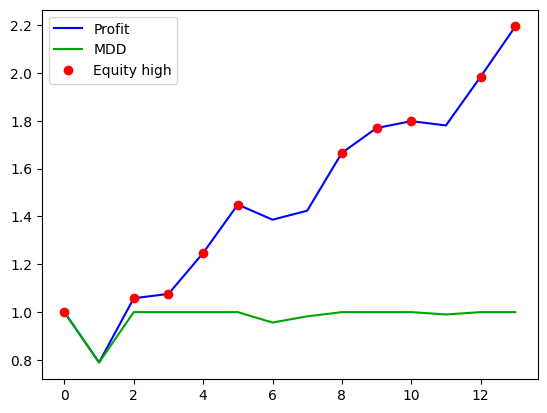

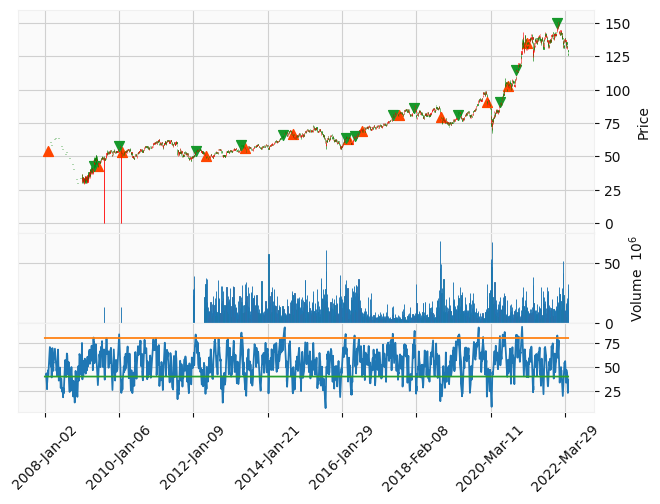

In [1]:
# 載入必要套件
from Data import getDataFM
from BackTest import ChartTrade, Performance
import pandas as pd
import mplfinance as mpf
from talib.abstract import RSI

# 取得回測資料
prod = "0050"
data = getDataFM(prod, "2007-01-01", "2022-05-01")

# 計算相對強弱指標 以及 買超 賣超
data["rsi"] = RSI(data, timeperiod=10)
over_buy = 80
over_sell = 40

# 初始部位
position = 0
trade = pd.DataFrame()
rsi_min, rsi_min_time = 100, 0
# 開始回測
for i in range(data.shape[0] - 1):
    # 取得策略會應用到的變數
    c_time = data.index[i]
    c_high = data.loc[c_time, "high"]
    c_close = data.loc[c_time, "close"]
    c_rsi = data.loc[c_time, "rsi"]
    # 取下一期資料做為進場資料
    n_time = data.index[i + 1]
    n_open = data.loc[n_time, "open"]

    # 進場程序
    if position == 0:
        if c_rsi < over_sell:
            # 如果當前 rsi 等於最小值 則變動
            if rsi_min > c_rsi:
                rsi_min = c_rsi
                rsi_min_time = i
                continue  # 直接換隔天
        # 判斷今天在最低點近三日 RSI反彈10
        if i <= rsi_min_time + 3 and c_rsi > rsi_min + 10:
            rsi_min = 100
            position = 1
            order_time = n_time
            order_price = n_open
            order_unit = 1

    # 出場程序
    elif position == 1:
        # 出場邏輯
        if c_rsi > over_buy:
            position = 0
            cover_time = n_time
            cover_price = n_open
            # 交易紀錄
            trade = trade._append(
                pd.Series(
                    [
                        prod,
                        "Buy",
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit,
                    ]
                ),
                ignore_index=True,
            )

# 繪製副圖
addp = []
addp.append(mpf.make_addplot(data["rsi"], panel=2, secondary_y=False))
addp.append(mpf.make_addplot([over_buy] * len(data["rsi"]), panel=2, secondary_y=False))
addp.append(
    mpf.make_addplot([over_sell] * len(data["rsi"]), panel=2, secondary_y=False)
)

# 績效分析
Performance(trade, "ETF")
# 繪製K線圖與交易明細
ChartTrade(data, trade, addp=addp)
